# Rubber Price Forecasting Project 

## Part 1: Problem Statement

### Problem Statements

**Goals for Decision Maker**<br>
Rubber cooperative want a model that forecast **Ribbed smoked sheet** prices for estimate trend next 1 month for increase chance of success speculate in Ribbed smoked sheet. 

**Goals for Develop Model**<br>
Build model to forecast **Ribbed smoked sheet** prices next 1 month to estimate trend of RSS prices for Rubber cooperative. Model performance will evaluate by `MAPE`. <br>
*Model will work in production part if performance better than baseline 5%.

### Background Information

When talking about the largest Rubber market in Thailand, 95% of Thai people would have to say that it is in the South of Thailand.

Data in year 2000 from the National Statistical Office of Thailand had shown number of totaled households in southern region is 2,900,000 and there are 1,000,000 households that have rubber plantation 
Now everyone that own rubber plantation are facing The Rubber price fluctuation which from various events in the world such as 
1. Declining demands medical gloves decreasing from unfolding in coronavirus situation
2. Semiconductor chips are in shortage and affect the vehicle industry dramatically curtailing production [source](https://www.thansettakij.com/economy/trade/538589)

Almost all rubber plantation owners sold their product to Rubber cooperatives.
Rubber cooperatives are also suffering from wrong decision in sold products lower price than it should to be and lost because from the Rubber prices fluctuation it make difficult to speculate.

**Wrong decision** came from chief person which they usually use instinct for making decision and when they wrong many time it make cooperative lack profit and chain to members of cooperative that they will lost dividends and also chain to rubber plantation owners that they will sold products in low price because cooperatives need to cut the purchase price to support themselves.

Rubber cooperative want to change their instinct-decision to data driven-decision and their first step is hiring junior data scientist to develop a model to forecast rubber price for next 1 month to estimate the future trend to increase success rate of speculation.

### Dataset

Rubber Dataset<br>
Data dictionary

variables|definition|
--|--|
cup_lump| Cup Lump Price|
rubber_sheet| Rubber Sheet Price|
ribbed_smoked_sheet| Ribbed Smoked Sheet Price|
latex| Latex Price|
fob| Free on Board Rubber Price|
tocom| Japan RSS3 Future Price|
sicom| Singapore RSS3 Future Price|
jpy| 1 Bath convert to Yen|
sgd| 1 Singapore dollar convert to Baht|
usd| 1 Bath convert to USD|
crude_oil| Crude oil Future Price|

From 
   1. [Rubber Prices 2560-2565](http://www.raot.co.th/ewt_news.php?nid=5662&filename=index)
   2. [FOB](http://www.raot.co.th/rubber2012/menu5.php)
   3. [Other Prices](https://www.investing.com/) 
   


## Part 2: Data Preparation

In [72]:
# import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import kaleido

# Set chart style to ggplot
import matplotlib
matplotlib.style.use('ggplot')

from scipy import stats


from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose

# set float number to only 2 decimal places
pd.options.display.float_format = '{:,.2f}'.format

### Import dataset
All data need to set date column as index for easily to analysis.

In [73]:
# create function for import data and set date type to datetime and set as index
# and set end date in october
def import_csv_dateindex(csv_file):
    """
    take path of csv file and return df which date col as index
    """
    df = pd.read_csv(f'../data/{csv_file}')
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df

#### Rubber types

In [74]:
# import rubber_price dataset and set date as index
rubber_price = import_csv_dateindex('rubber_price.csv')
rubber_price.head()

latex  cup_lump  rubber_sheet  ribbed_smoked_sheet
date                                                          
2017-09-19    NaN       NaN         52.56                55.04
2017-09-20    NaN       NaN         51.51                53.28
2017-09-21    NaN       NaN         51.51                53.14
2017-09-22    NaN       NaN         51.78                53.30
2017-09-25    NaN       NaN         50.58                53.22

In [75]:
# check types of all columns
# all columns store in correct type which is float
rubber_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2017-09-19 to 2022-10-31
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latex                809 non-null    float64
 1   cup_lump             1052 non-null   float64
 2   rubber_sheet         1240 non-null   float64
 3   ribbed_smoked_sheet  1240 non-null   float64
dtypes: float64(4)
memory usage: 48.4 KB


In [76]:
# count value in rubber_price df
rubber_price.resample('y').count()

latex  cup_lump  rubber_sheet  ribbed_smoked_sheet
date                                                          
2017-12-31      0         0            69                   69
2018-12-31      0       123           242                  242
2019-12-31    120       239           239                  239
2020-12-31    243       244           244                  244
2021-12-31    246       246           246                  246
2022-12-31    200       200           200                  200

**Latex** is empty in year 2017 and 2018 and have half in 2019. 

**Cup Lump** is empty in year 2017 and have half in year 2018. 

#### FOB

In [77]:
# import fob dataset and set date as index
fob = import_csv_dateindex('FOB.csv')
fob.head()

rubber_sheet  latex  bid_rubber_sheet  bid_rss  bid_latex   fob
date                                                                       
2001-01-03         22.30  20.00             23.55    24.26        NaN 26.70
2001-01-04         22.30  19.50             23.25    24.30        NaN 26.25
2001-01-05         22.30  19.25             23.26    24.16        NaN 26.25
2001-01-08         22.30  19.25             23.45    24.20        NaN 25.85
2001-01-09         22.20  19.25             23.26    24.26        NaN 25.90

In [78]:
# check types of all columns
# all columns store in correct type which is float
fob.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5260 entries, 2001-01-03 to 2022-10-31
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rubber_sheet      5245 non-null   float64
 1   latex             5246 non-null   float64
 2   bid_rubber_sheet  5019 non-null   float64
 3   bid_rss           5221 non-null   float64
 4   bid_latex         1843 non-null   float64
 5   fob               5250 non-null   float64
dtypes: float64(6)
memory usage: 287.7 KB


In [79]:
# count value in fob df
fob.resample('y').count()

rubber_sheet  latex  bid_rubber_sheet  bid_rss  bid_latex  fob
date                                                                      
2001-12-31           244    244               244      243          0  242
2002-12-31           245    245               246      246          0  246
2003-12-31           244    244               244      244          0  243
2004-12-31           241    241               241      241        146  241
2005-12-31           234    234               234      234        234  234
2006-12-31           237    237               235      236        235  237
2007-12-31           241    241               241      241        241  241
2008-12-31           244    244               244      244        244  244
2009-12-31           238    238               238      238        238  238
2010-12-31           238    238               238      238        238  238
2011-12-31           242    241               242      242        240  242
2012-12-31           242    243               241      240         21  243
2013-12-31           242    243               241      241          0  243
2014-12-31           238    238               237      238          0  238
2015-12-31           238    238               238      238          0  238
2016-12-31           241    241               239      239          0  240
2017-12-31           238    235               236      232          0  238
2018-12-31           238    238               232      236          0  238
2019-12-31           235    235               221      233          5  237
2020-12-31           241    243               174      238          0  244
2021-12-31           247    247               182      242          0  247
2022-12-31           197    198               131      197          1  198

this dataset contain Rubber sheet and Latex prices might same as `rubber_price` df and also have bid rubber price which is not relate to my goal.

**bid prices** is when you want to buy rubber from other people that had sold to government and government will allocate for someone or SME to bidding it.

fob is free on board rubber price which is ribbed smoked sheet in dice form price that foreign company (e.g. company from japan etc.) propose to buy it.

#### Related Prices

In [80]:
# import fob dataset and set date as index
related_prices = import_csv_dateindex('related_prices.csv')
related_prices.head()

tocom  sicom  jpy  sgd  usd  crude_oil
date                                              
2010-12-03 361.70    NaN  NaN  NaN  NaN        NaN
2010-12-06 366.80    NaN 2.75  NaN 0.03      89.74
2010-12-07 368.50    NaN 2.78  NaN 0.03      89.22
2010-12-08 369.30    NaN 2.79  NaN 0.03      88.82
2010-12-09 372.00    NaN 2.78  NaN 0.03      88.88

In [81]:
# check types of all columns
# all columns store in correct type which is float
related_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3144 entries, 2010-12-03 to 2022-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tocom      2916 non-null   float64
 1   sicom      1891 non-null   float64
 2   jpy        3106 non-null   float64
 3   sgd        3102 non-null   float64
 4   usd        3106 non-null   float64
 5   crude_oil  3106 non-null   float64
dtypes: float64(6)
memory usage: 171.9 KB


In [82]:
# check missing values group in year
related_prices.resample('y').count()

tocom  sicom  jpy  sgd  usd  crude_oil
date                                              
2010-12-31     19      0   20   16   20         19
2011-12-31    245      0  260  260  260        252
2012-12-31    248      0  261  261  261        252
2013-12-31    245      0  261  261  261        256
2014-12-31    244      0  261  261  261        260
2015-12-31    244    187  261  261  261        264
2016-12-31    245    251  261  261  261        264
2017-12-31    247    249  260  260  260        263
2018-12-31    247    249  261  261  261        264
2019-12-31    242    248  261  261  261        264
2020-12-31    243    250  262  262  262        264
2021-12-31    245    251  261  261  261        263
2022-12-31    202    206  216  216  216        221

All data in year before 2015 are missing a lot but it not my concern because I will use only data in years 2017 - 2022 because main target is rss prices column which only had data in years 2017 - 2022.

### Merge all df

`Latex` column in `rubber_price` and `fob` df are shown. but in rubber_price df are missing in years 2017 - 2018. So, I need to check that latex prices in fob df are same?

In [83]:
# merge latex column in fob and rubber_price
test_latex_price = pd.merge(fob['latex'].dropna(), rubber_price['latex'].dropna(), 
                how='left', left_index=True,right_index=True).dropna()

In [84]:
# check values that they are same
print(f'Rows of latex columns in rubber_price {test_latex_price.shape[0]}')
print(f"The value of Latex price in fob df has equal values with Latex in rubber_price is\
 {(test_latex_price['latex_x'] == test_latex_price['latex_y']).sum()}")

Rows of latex columns in rubber_price 808
The value of Latex price in fob df has equal values with Latex in rubber_price is 803


From value above almost prices in Latex columns are the same. Thus, I decided to drop latex prices from rubber_price and use latex price from fob df instead because fob df contain latex prices more than rubber_price df.

In [85]:
# merge rubber price and fob select only fob price
# for rubber_price drop latex
rubber = pd.merge(rubber_price.drop(columns='latex'), fob[['latex', 'fob']], how='left', left_index=True,right_index=True)

# merge rubber and related_prices
rubber = pd.merge(rubber, related_prices, how='left', left_index=True,right_index=True)

In [86]:
rubber.resample('y').count()

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex  fob  tocom  \
date                                                                         
2017-12-31         0            69                   69     69   69     66   
2018-12-31       123           242                  242    238  238    230   
2019-12-31       239           239                  239    235  237    225   
2020-12-31       244           244                  244    243  244    229   
2021-12-31       247           247                  247    247  247    235   
2022-12-31       200           200                  200    198  198    187   

            sicom  jpy  sgd  usd  crude_oil  
date                                         
2017-12-31     67   69   69   69         69  
2018-12-31    234  242  242  242        241  
2019-12-31    231  239  239  239        238  
2020-12-31    235  244  244  244        242  
2021-12-31    240  247  247  247        245  
2022-12-31    194  200  200  200        200

For some columns they still have missing values but I will leave it there for now because I will decide to drop or impute in the feature selection part.

### Duplicate Data

In [87]:
# finding duplicate data
rubber[rubber.index.duplicated()]

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex   fob  tocom  \
date                                                                          
2021-07-13     43.50         50.83                52.32  44.50 59.20 213.90   

            sicom  jpy   sgd  usd  crude_oil  
date                                          
2021-07-13 185.50 3.39 24.07 0.03      65.03

In [88]:
# check for duplicate values
rubber.loc['2021-07-13']

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex   fob  tocom  \
date                                                                          
2021-07-13     43.50         50.83                52.32  44.50 59.20 213.90   
2021-07-13     43.50         50.83                52.32  44.50 59.20 213.90   

            sicom  jpy   sgd  usd  crude_oil  
date                                          
2021-07-13 185.50 3.39 24.07 0.03      65.03  
2021-07-13 185.50 3.39 24.07 0.03      65.03

Found that date 2021-07-13 is duplicated values. Need to drop it.

In [89]:
# filter duplicate value and save only first one
rubber = rubber[~rubber.index.duplicated(keep='first')]

In [90]:
# check result
rubber.loc[['2021-07-13']]

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex   fob  tocom  \
date                                                                          
2021-07-13     43.50         50.83                52.32  44.50 59.20 213.90   

            sicom  jpy   sgd  usd  crude_oil  
date                                          
2021-07-13 185.50 3.39 24.07 0.03      65.03

In [91]:
# set index to be business day
rubber = rubber.resample('B').mean()

In [92]:
# check resample working correctly 
# 0-4 are in weekdays and 5, 6 are in weekends
rubber[rubber.index.weekday >= 5]

Empty DataFrame
Columns: [cup_lump, rubber_sheet, ribbed_smoked_sheet, latex, fob, tocom, sicom, jpy, sgd, usd, crude_oil]
Index: []

In [93]:
# check frequency type
rubber.index.freq

<BusinessDay>

### Missing Values

In [94]:
# fill missing values with last observed value
rubber.fillna(method='ffill', inplace=True)

I fill missing values with last observed fill method because central market closed in holiday but the price are still the same as yesterday.

In [95]:
# check fill na work correctly
rubber.head()

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex   fob  tocom  \
date                                                                          
2017-09-19       NaN         52.56                55.04  51.50 60.10 208.80   
2017-09-20       NaN         51.51                53.28  50.50 59.70 210.00   
2017-09-21       NaN         51.51                53.14  50.00 59.70 207.80   
2017-09-22       NaN         51.78                53.30  50.00 58.70 207.00   
2017-09-25       NaN         50.58                53.22  50.00 58.70 207.00   

            sicom  jpy   sgd  usd  crude_oil  
date                                          
2017-09-19 174.30 3.37 24.56 0.03      51.77  
2017-09-20 178.20 3.39 24.54 0.03      51.79  
2017-09-21 175.30 3.40 24.53 0.03      51.63  
2017-09-22 176.50 3.39 24.58 0.03      51.67  
2017-09-25 178.00 3.38 24.50 0.03      51.41

In [96]:
# check missing values
rubber.isna().sum()

cup_lump               204
rubber_sheet             0
ribbed_smoked_sheet      0
latex                    0
fob                      0
tocom                    0
sicom                    0
jpy                      0
sgd                      0
usd                      0
crude_oil                0
dtype: int64

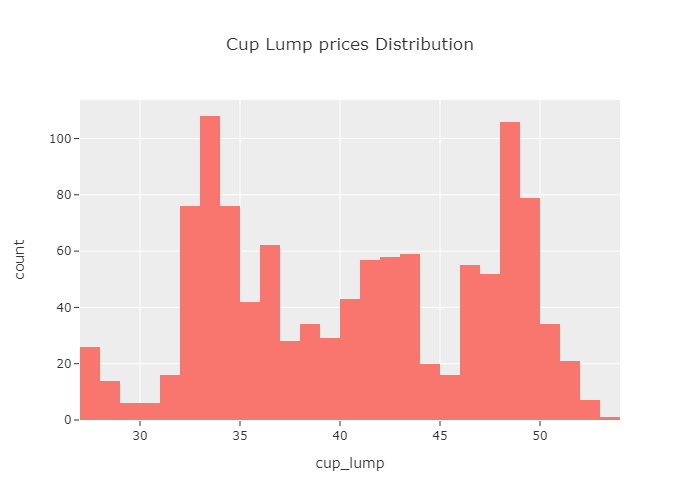

In [97]:
# plot distribution chart in cup lump column
px.histogram(rubber, x=rubber['cup_lump'], template='ggplot2', title='Cup Lump prices Distribution').show('png')

In [98]:
# calculate cup lump statistics
rubber['cup_lump'].describe()

count   1,131.00
mean       40.49
std         6.71
min        27.00
25%        34.20
50%        40.90
75%        47.00
max        53.30
Name: cup_lump, dtype: float64

In [99]:
# calculate cup lump median
rubber['cup_lump'].median()

40.9

In [100]:
# find mode in cup lump
rubber['cup_lump'].mode()

0   36.00
1   48.50
Name: cup_lump, dtype: float64

For Cup Lump it not fill missing values because the value start collected at year 2018 and I will decide to impute or remove it when modeling.

---

## Part 3: EDA

In [101]:
# average and median split by year
rubber.resample('y')['ribbed_smoked_sheet'].agg(['mean', 'median'])

mean  median
date                    
2017-12-31 48.89   47.09
2018-12-31 45.81   46.03
2019-12-31 47.10   45.52
2020-12-31 49.43   44.36
2021-12-31 59.19   58.50
2022-12-31 60.76   61.07

In [102]:
# average and median split by quarter
rubber.resample('q')['ribbed_smoked_sheet'].agg(['mean', 'median'])

mean  median
date                    
2017-09-30 53.80   53.49
2017-12-31 48.21   47.00
2018-03-31 47.82   48.00
2018-06-30 49.72   49.62
2018-09-30 44.25   44.60
2018-12-31 41.51   41.39
2019-03-31 47.96   46.72
2019-06-30 55.22   54.35
2019-09-30 44.92   42.39
2019-12-31 40.46   39.94
2020-03-31 43.02   42.90
2020-06-30 40.74   40.03
2020-09-30 50.12   49.03
2020-12-31 63.61   62.34
2021-03-31 61.76   60.75
2021-06-30 64.46   63.91
2021-09-30 53.53   53.09
2021-12-31 57.16   57.01
2022-03-31 63.31   64.07
2022-06-30 68.97   69.11
2022-09-30 53.23   50.70
2022-12-31 51.27   51.00

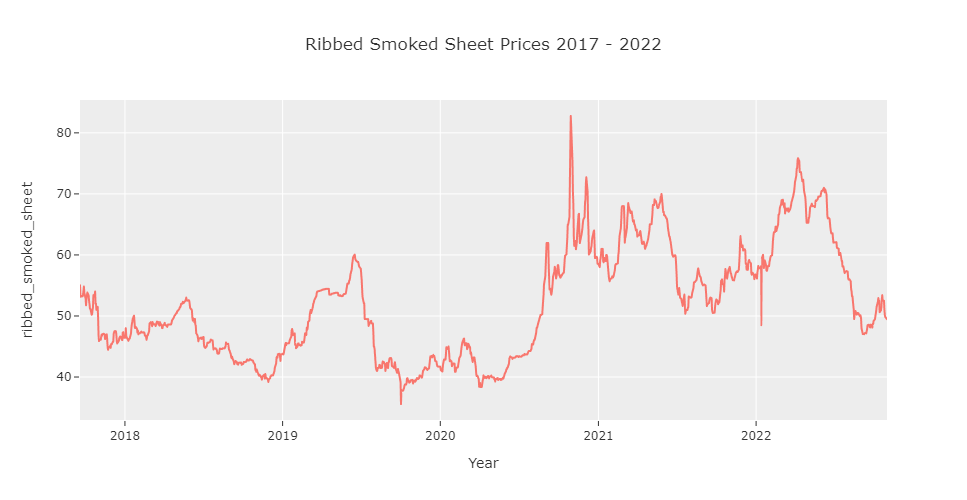

In [103]:
# plot ribbed_smoked_sheet price line chart
px.line(rubber, y="ribbed_smoked_sheet",title='Ribbed Smoked Sheet Prices 2017 - 2022',
        template='ggplot2', labels={'value':'Price', 'date':'Year'}, width=1000, height=500)

From chart above it roughly hard to try analyze the chart because price are swing and messy. So, I decide to do a rolling for 1 month for smooth line chart.

In [104]:
# create function for plot line chart with moving average data
def plot_line(li_cols, rolling, df, title=None):
    # need to drop na for make line connected
    fig = px.line(df.rolling(rolling).mean().dropna(subset=li_cols), y=li_cols,
        title=title,
        template='ggplot2', labels={'value':'Price', 'date':'Year', 'variable':'Rubber types'},
                 width=1000, height=500)
    fig.show()

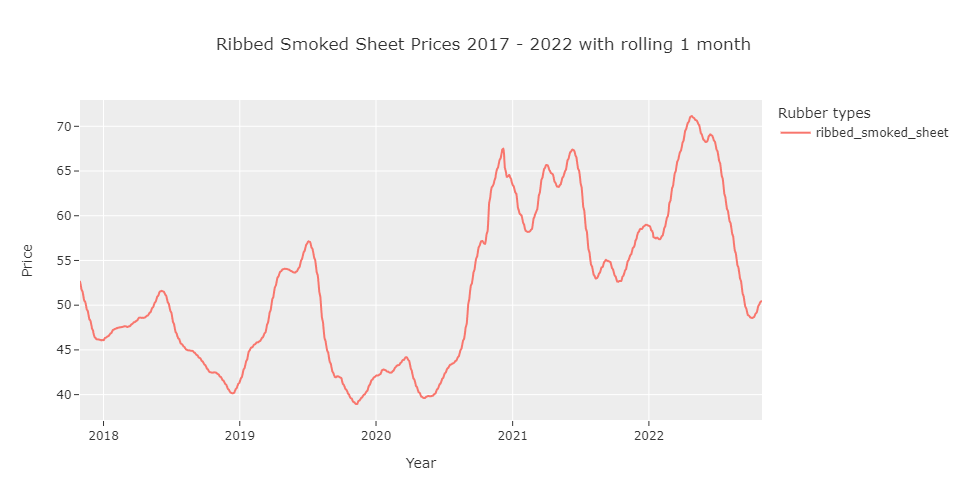

In [105]:
# plot ribbed_smoked_sheet price line chart
plot_line(['ribbed_smoked_sheet'], 30, rubber, 'Ribbed Smoked Sheet Prices 2017 - 2022 with rolling 1 month')

**Analysis**
- Ribbed smoke sheet prices have a chance to have seasonality
- Price will always rise up in middle of the year
- Price will always fall down in last of the year

### Rubber Types

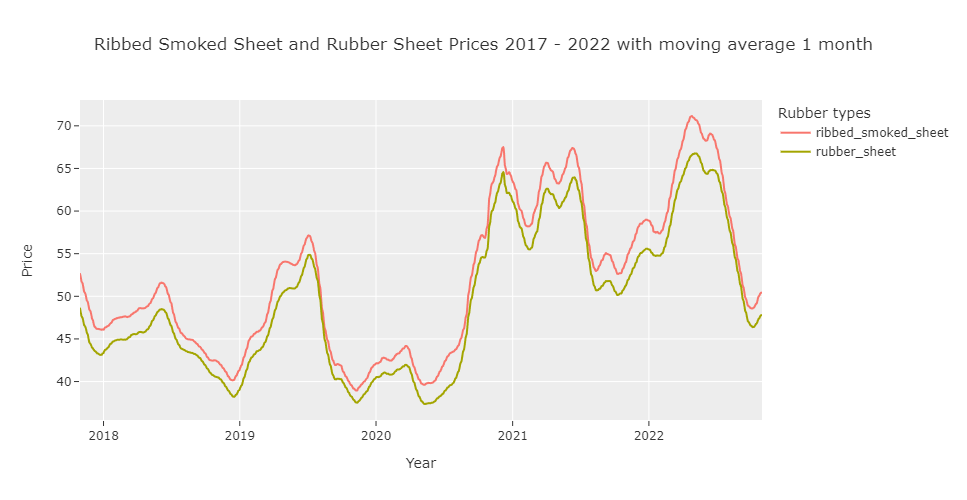

In [106]:
# plot ribbed_smoked_sheet and rubber_sheet price line chart
plot_line(['ribbed_smoked_sheet', 'rubber_sheet'], 30,
          rubber, title = 'Ribbed Smoked Sheet and Rubber Sheet Prices 2017 - 2022 with moving average 1 month')

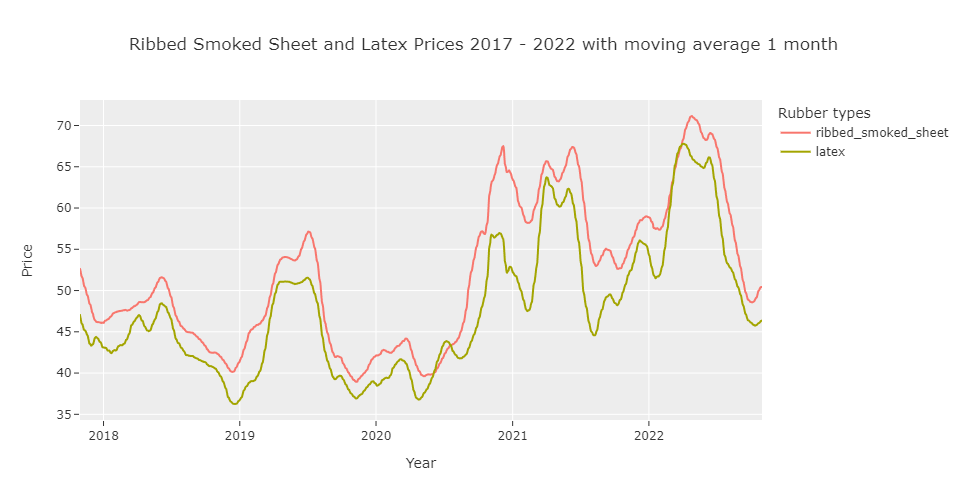

In [107]:
# plot ribbed_smoked_sheet and latex prices line chart
plot_line(['ribbed_smoked_sheet', 'latex'], 30,
          rubber, title = 'Ribbed Smoked Sheet and Latex Prices 2017 - 2022 with moving average 1 month')

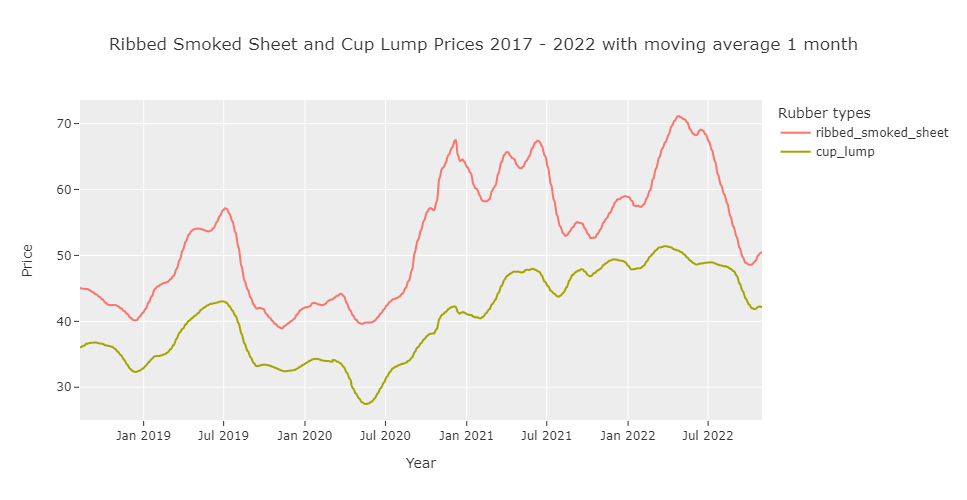

In [108]:
# plot ribbed_smoked_sheet and cup_lump prices line chart
plot_line(['ribbed_smoked_sheet', 'cup_lump'], 30,
          rubber, title = 'Ribbed Smoked Sheet and Cup Lump Prices 2017 - 2022 with moving average 1 month')

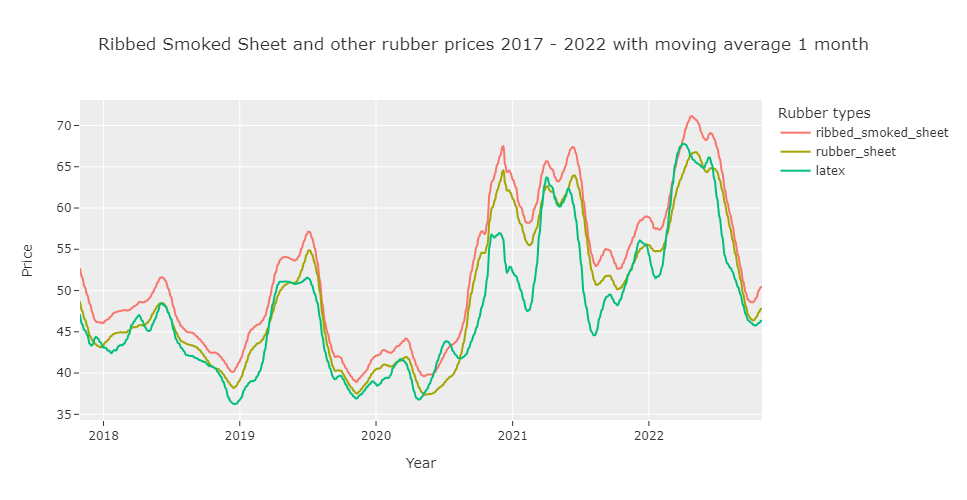

In [137]:
# plot ribbed_smoked_sheet and other rubber types prices line chart
plot_line(['ribbed_smoked_sheet', 'rubber_sheet', 'latex'], 30,
          rubber, title = 'Ribbed Smoked Sheet and other rubber prices\
 2017 - 2022 with moving average 1 month')

All rubber types prices are correlate to each other they rarely to had different trends.

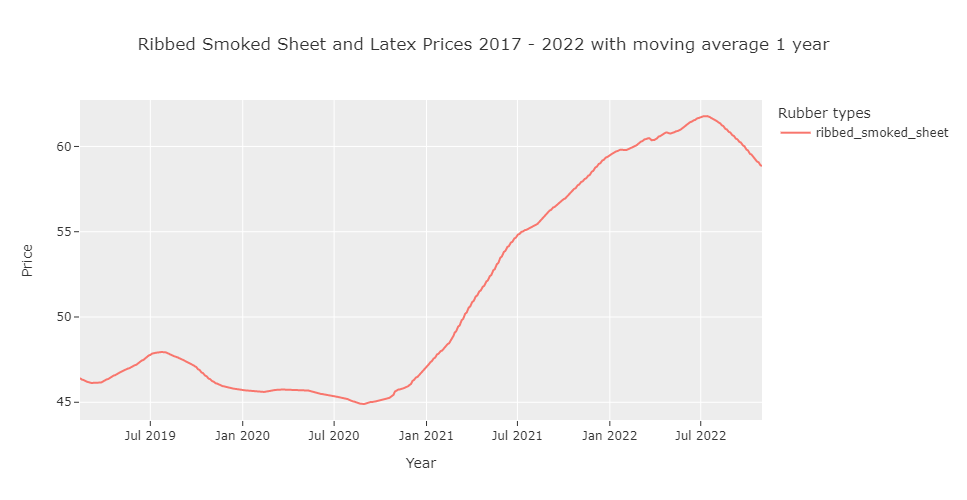

In [110]:
# plot ribbed_smoked_sheet and moving average for 1 year line chart
plot_line(['ribbed_smoked_sheet'], 365,
          rubber, title = 'Ribbed Smoked Sheet and Latex Prices 2017 - 2022 with moving average 1 year')

From chart above ribbed smoked sheet have trend price increase from year 2019 to year 2022

### Futures
For RSS prices compare to other features that is not THB currency we need to standardize to all prices for easily to compare.

In [111]:
# apply standardize function to df and store as new df
rubber_sc = rubber.apply(stats.zscore)
rubber_sc.head()

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex  fob  tocom  \
date                                                                         
2017-09-19       NaN          0.36                 0.34   0.44 0.27   0.21   
2017-09-20       NaN          0.24                 0.14   0.32 0.23   0.24   
2017-09-21       NaN          0.24                 0.13   0.26 0.23   0.18   
2017-09-22       NaN          0.27                 0.15   0.26 0.12   0.16   
2017-09-25       NaN          0.13                 0.14   0.26 0.12   0.16   

            sicom   jpy  sgd   usd  crude_oil  
date                                           
2017-09-19  -0.11 -0.83 0.84 -0.56      -0.46  
2017-09-20   0.02 -0.71 0.82 -0.56      -0.46  
2017-09-21  -0.07 -0.66 0.81 -0.56      -0.47  
2017-09-22  -0.03 -0.75 0.86 -0.56      -0.47  
2017-09-25   0.01 -0.82 0.78 -0.56      -0.49

#### Tocom

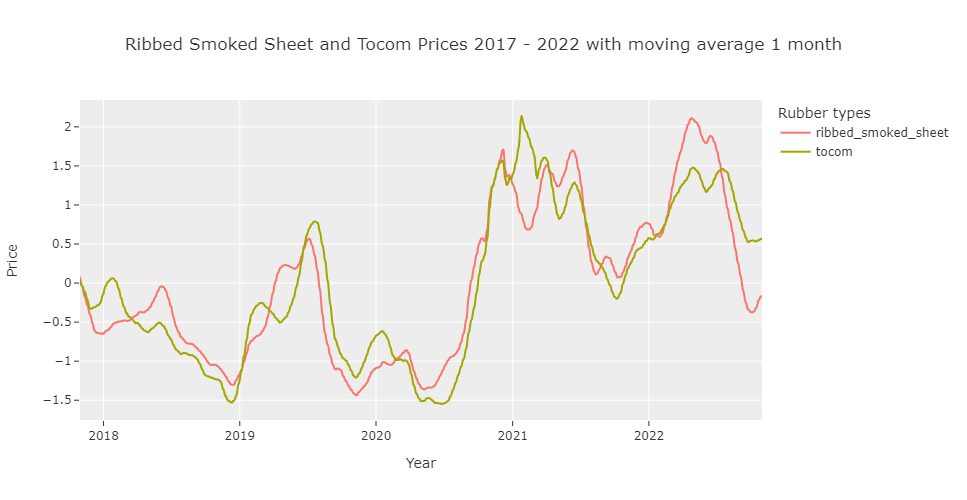

In [112]:
# plot ribbed_smoked_sheet and latex prices line chart
plot_line(['ribbed_smoked_sheet', 'tocom'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and Tocom Prices 2017 - 2022 with moving average 1 month')

#### Sicom

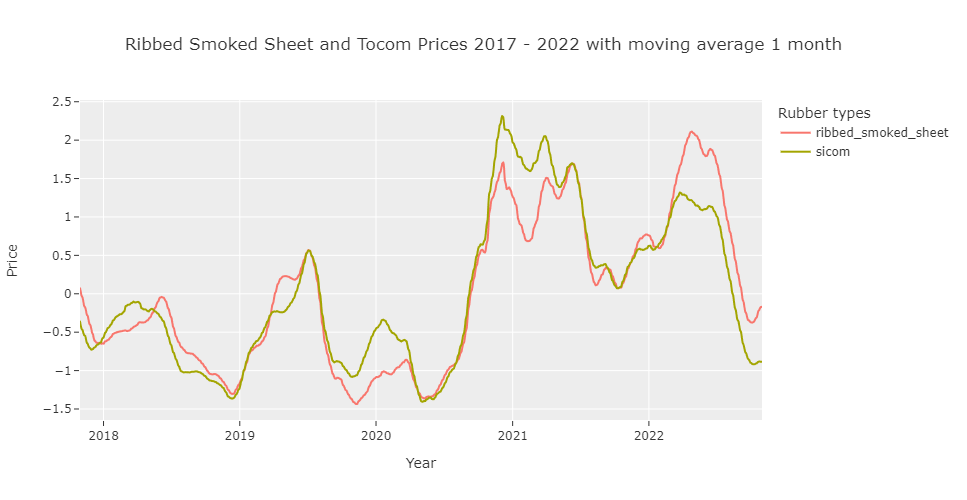

In [113]:
# plot ribbed_smoked_sheet and sicom prices line chart
plot_line(['ribbed_smoked_sheet', 'sicom'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and Tocom Prices 2017 - 2022 with moving average 1 month')

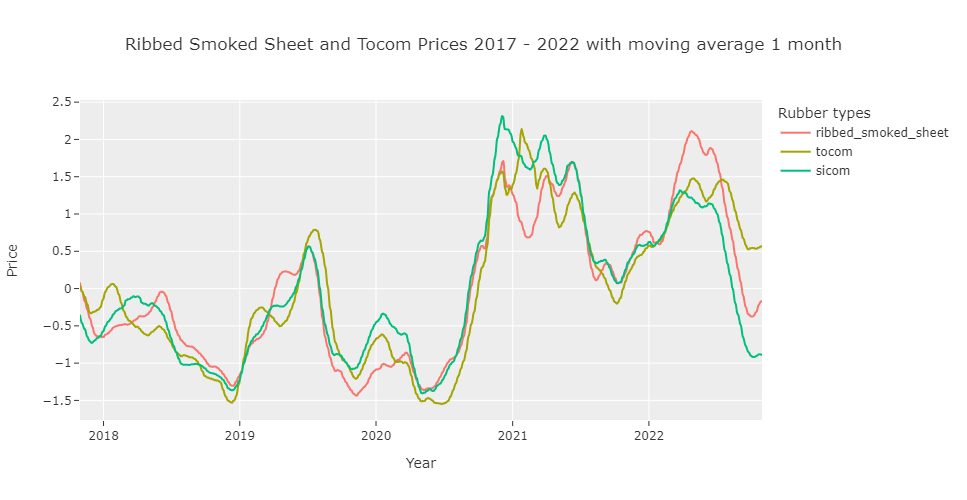

In [114]:
# plot ribbed_smoked_sheet and sicom prices line chart
plot_line(['ribbed_smoked_sheet', 'tocom', 'sicom'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and Tocom Prices 2017 - 2022 with moving average 1 month')

### Currency

#### THB convert to JPY

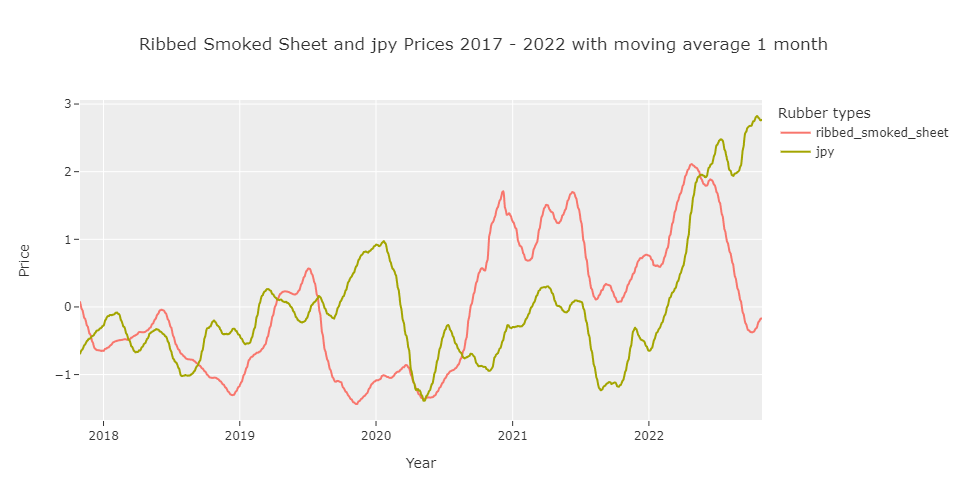

In [115]:
# plot ribbed_smoked_sheet and jpy prices line chart
plot_line(['ribbed_smoked_sheet', 'jpy'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and jpy Prices 2017 - 2022 with moving average 1 month')

#### SGD Convert to THB

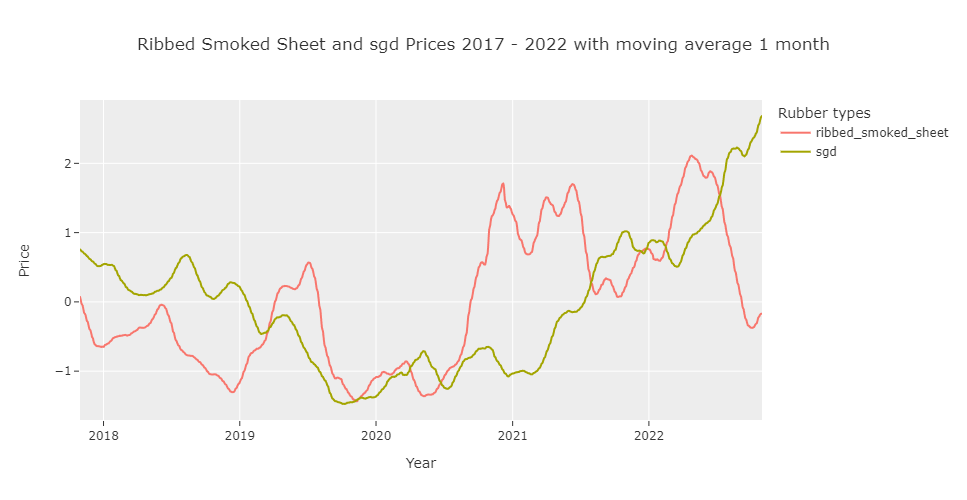

In [116]:
# plot ribbed_smoked_sheet and sgd prices line chart
plot_line(['ribbed_smoked_sheet', 'sgd'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and sgd Prices 2017 - 2022 with moving average 1 month')

#### THB Convert to USD

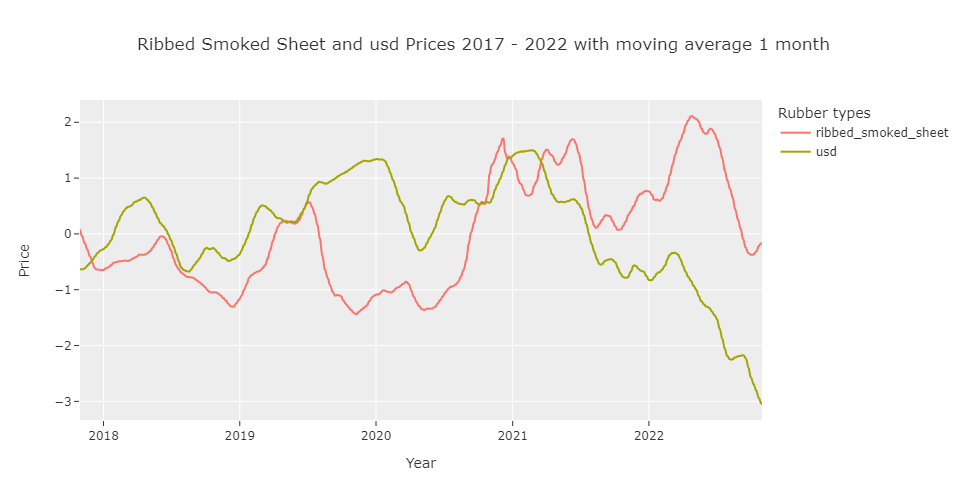

In [117]:
# plot ribbed_smoked_sheet and usd prices line chart
plot_line(['ribbed_smoked_sheet', 'usd'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and usd Prices 2017 - 2022 with moving average 1 month')

USD prices are not quite showing the trend for rss price whihc I will drop it.

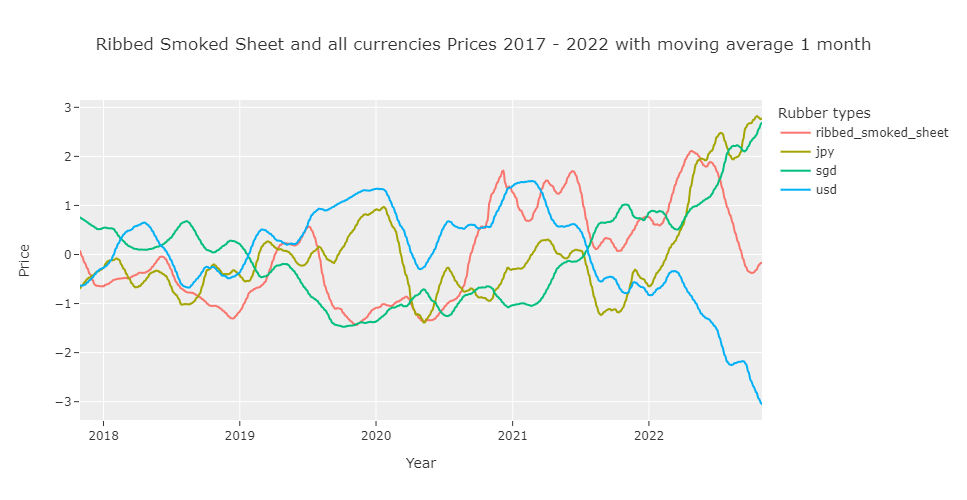

In [136]:
# plot ribbed_smoked_sheet and usd prices line chart
plot_line(['ribbed_smoked_sheet', 'jpy', 'sgd','usd'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and all currencies Prices 2017 - 2022 with moving average 1 month')

### Other commodity

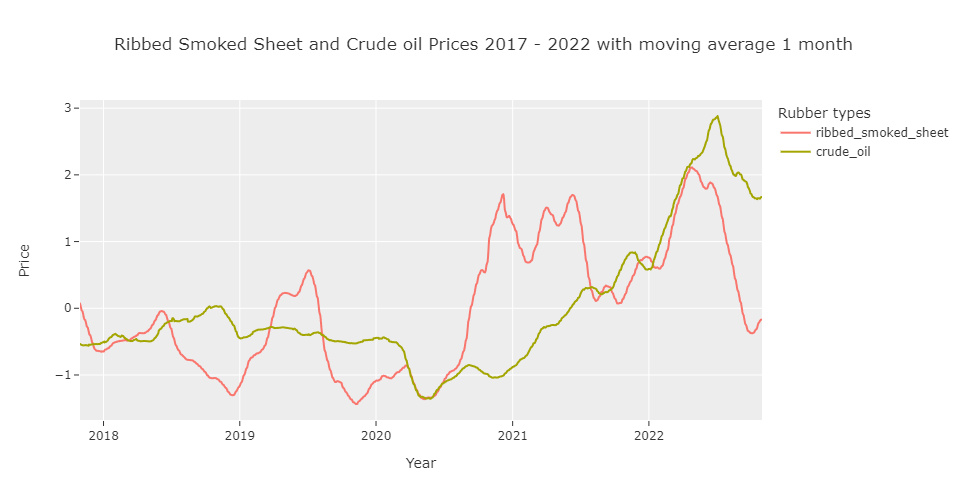

In [119]:
# plot ribbed_smoked_sheet and usd prices line chart
plot_line(['ribbed_smoked_sheet', 'crude_oil'], 30,
          rubber_sc, title = 'Ribbed Smoked Sheet and Crude oil Prices 2017 - 2022 with moving average 1 month')

For Crude oil it showing that they moderate association which if rss price are increase curde oil price sometimes also up as well.

### Correlation

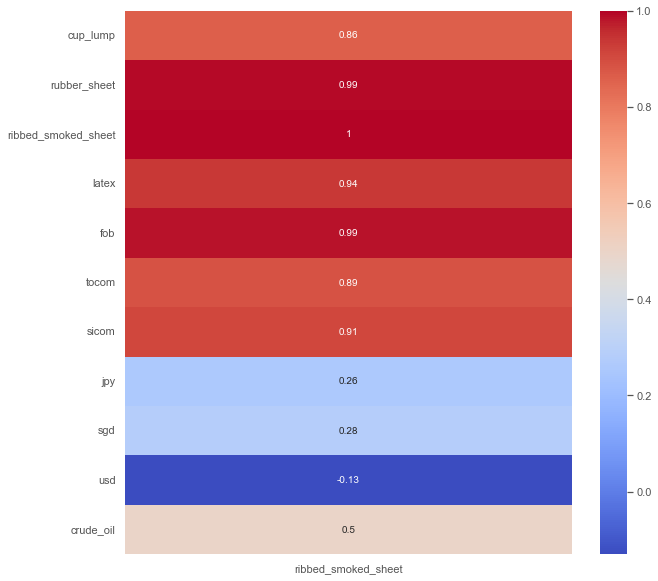

In [120]:
plt.figure(figsize=(10, 10))
sns.heatmap(rubber.corr()[['ribbed_smoked_sheet']], annot=True, cmap='coolwarm');

I decided to drop `usd` because it not meet at least moderate correlate.

In [121]:
# additional datetime columns: feature engineering
rubber_corr = rubber.copy()
rubber_corr["month"] = rubber_corr.index.month

rubber_corr["wday"] = rubber_corr.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri"}
rubber_corr["weekday"] = rubber_corr["wday"].apply(lambda x: dict_days[x])

rubber_corr["quarter"] = rubber_corr.index.quarter
rubber_corr["year"] = rubber_corr.index.year

rubber_corr.iloc[[0, -1]]

cup_lump  rubber_sheet  ribbed_smoked_sheet  latex   fob  tocom  \
date                                                                          
2017-09-19       NaN         52.56                55.04  51.50 60.10 208.80   
2022-10-31     40.75         47.03                49.47  47.00 58.15 215.70   

            sicom  jpy   sgd  usd  crude_oil  month  wday weekday  quarter  \
date                                                                         
2017-09-19 174.30 3.37 24.56 0.03      51.77      9     1   2_Tue        3   
2022-10-31 149.90 3.91 26.87 0.03      86.53     10     0   1_Mon        4   

            year  
date              
2017-09-19  2017  
2022-10-31  2022

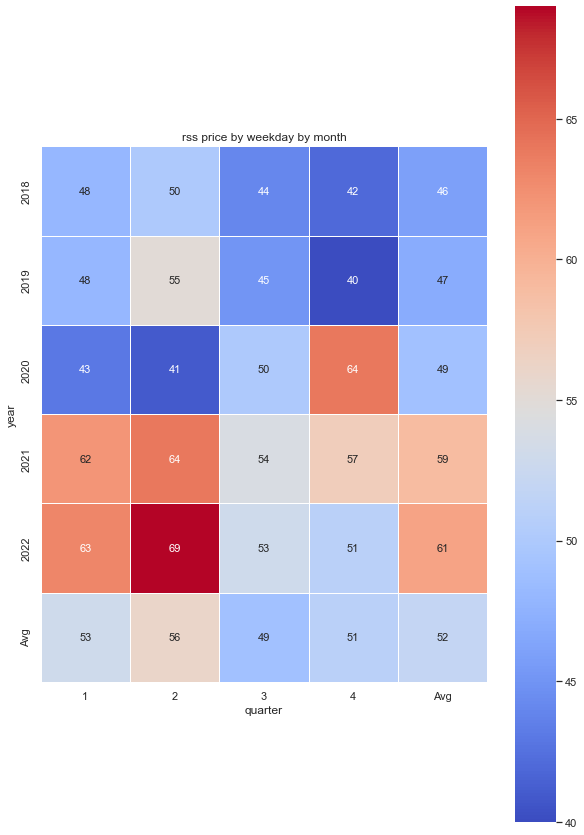

In [122]:
# pivot table: quarter in year
piv = pd.pivot_table(   rubber_corr.drop('cup_lump', axis=1).loc['2018':], 
                        values="ribbed_smoked_sheet", 
                        index="year", 
                        columns="quarter", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("rss price by weekday by month")
plt.show()

Found that rss price will increase in quarter 1, 2. So, I decided to investigate further in each month.

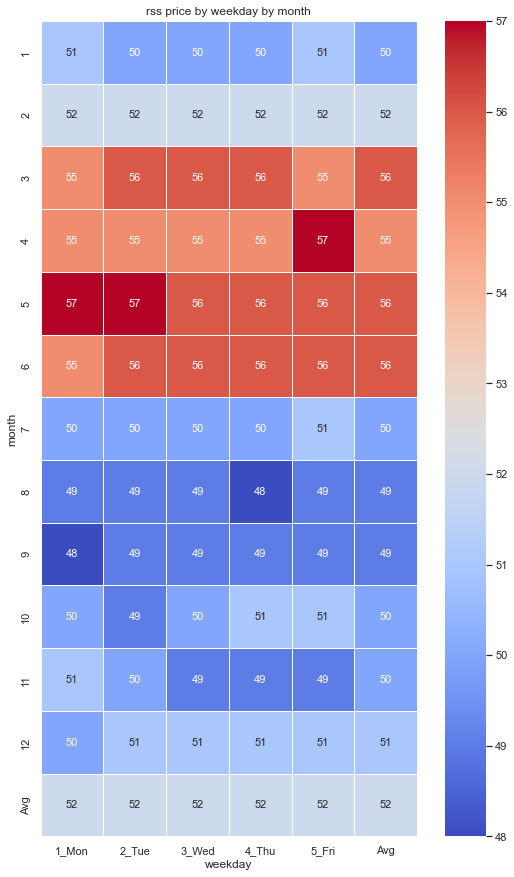

In [123]:
# pivot table: weekdays in months
piv = pd.pivot_table(   rubber_corr, 
                        values="ribbed_smoked_sheet", 
                        index="month", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("rss price by weekday by month")
plt.show()

The rss price will have higher price in month 3, 4, 5, 6.

### Seasonality

In [124]:
def create_corr_plot(series, title=None, plot_pacf=False):
    """
    take time series data and plot autocorrelation or partial autocorrelation
    source: https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108
    """
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines', fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title=f'{title} Partial Autocorrelation (PACF)' if plot_pacf else f'{title} Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show('png')

In [125]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    """
    take df that using seasonal decompose and return chart seasonal decompose in plotly form.
    source: https://gist.github.com/tomron/8798256fcee5438edd58c17654adf443
    """
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
        .show('png')
    )

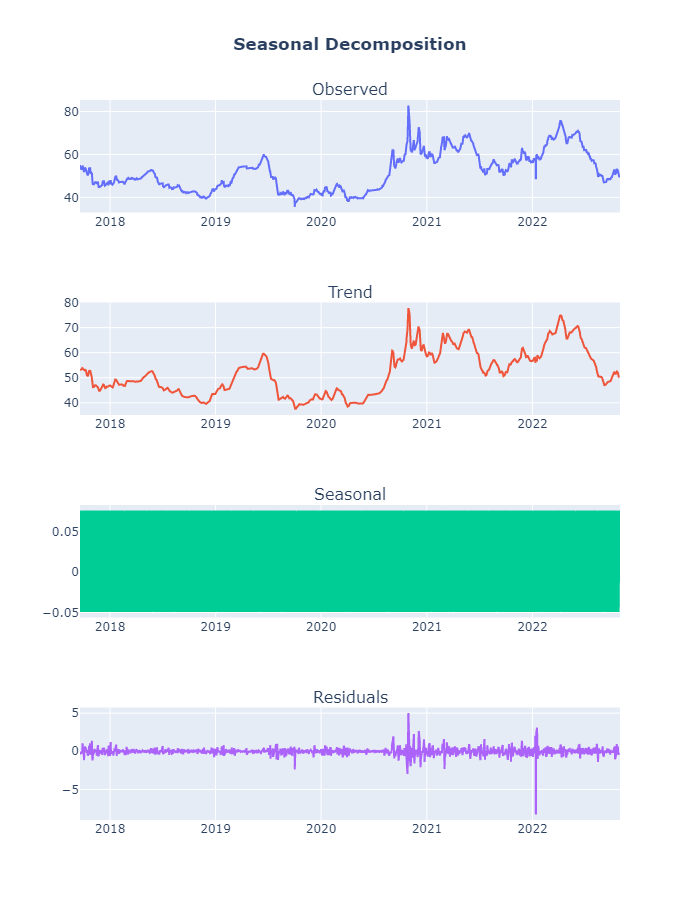

In [126]:
# decompose seasonality but for Business day frequenty 
# it too much in seasonal so I decided to more specific in 2022
decomposition = seasonal_decompose(rubber['ribbed_smoked_sheet'])
plot_seasonal_decompose(decomposition, dates=rubber.index)

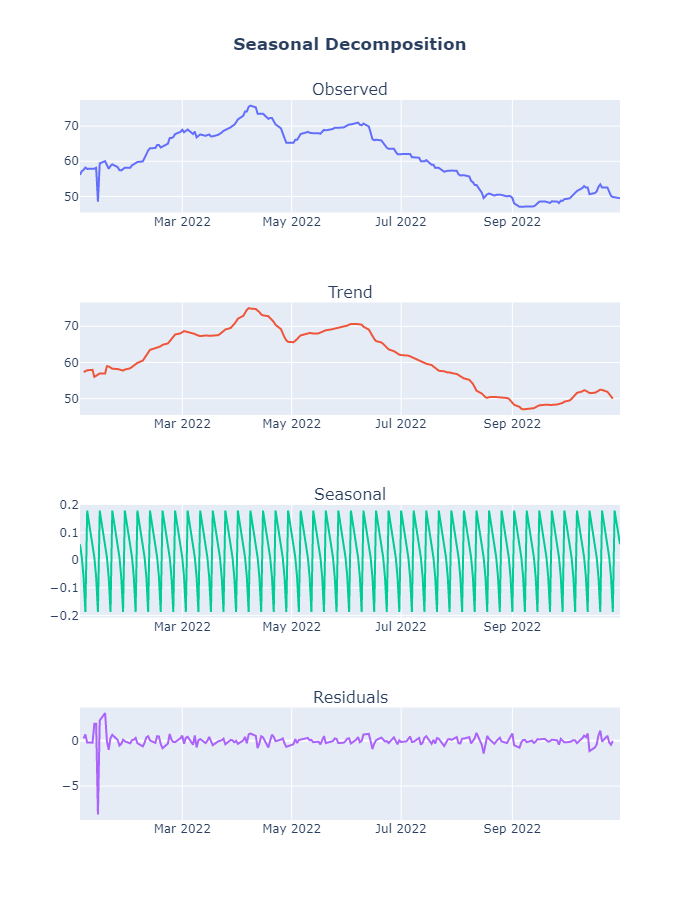

In [127]:
# decompose seasonality in 2022 for easily to interpret
decomposition = seasonal_decompose(rubber['ribbed_smoked_sheet'].loc['2022'])
plot_seasonal_decompose(decomposition, dates=rubber.loc['2022'].index)

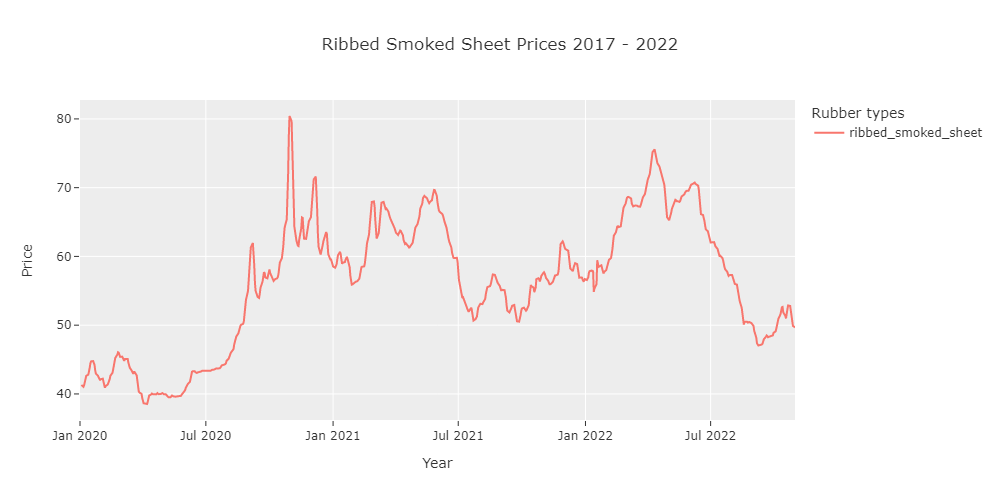

In [128]:
# plot ribbed_smoked_sheet price line chart
px.line(rubber.loc['2020':'2022'].rolling(3).mean(), y=["ribbed_smoked_sheet"],title='Ribbed Smoked Sheet Prices 2017 - 2022',
        template='ggplot2', labels={'value':'Price', 'date':'Year', 'variable':'Rubber types'},
       width=1000, height=500).show('png')

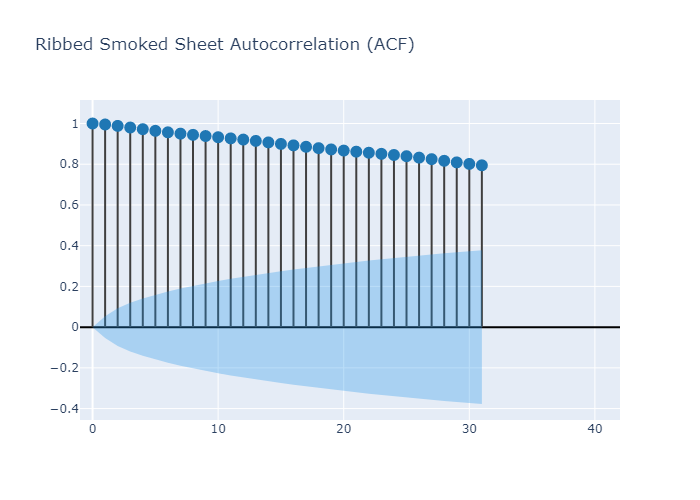

In [129]:
create_corr_plot(rubber['ribbed_smoked_sheet'], 'Ribbed Smoked Sheet')

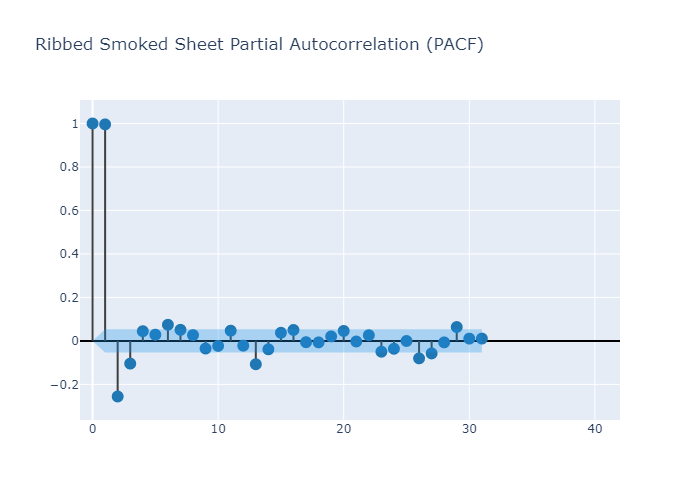

In [130]:
create_corr_plot(rubber['ribbed_smoked_sheet'], 'Ribbed Smoked Sheet', plot_pacf=True)

From partial autocorrelation and autocorrelation chart rss daily prices doesn't show the seasonality So for now I assume there are no seasonality.

### Stationary

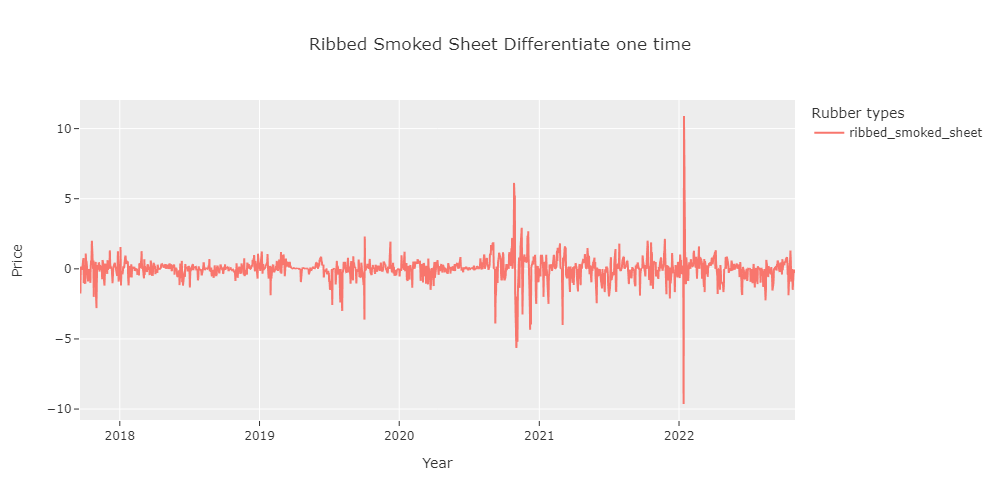

In [131]:
# plot ribbed_smoked_sheet price line chart
px.line(rubber.diff(), y=["ribbed_smoked_sheet"],title='Ribbed Smoked Sheet Differentiate one time',
        template='ggplot2', labels={'value':'Price', 'date':'Year', 'variable':'Rubber types'},
       width=1000, height=500).show('png')

From chart above found that in 2022 they have price fluctuation which I will investigate that those values are outlier or not.

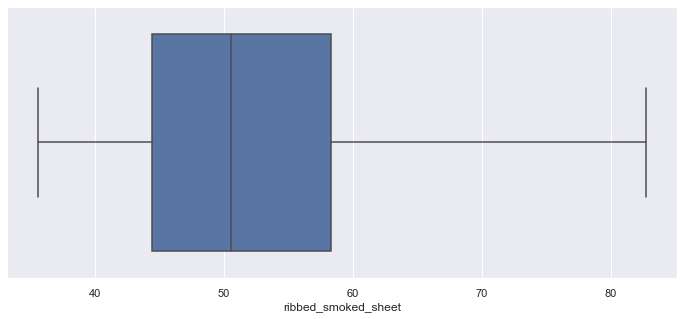

In [132]:
# find outliers with 3 IQR criteria
plt.figure(figsize=(12, 5))
sns.boxplot(x='ribbed_smoked_sheet', data=rubber, whis=3);

They are no outlier in 3 IQR criteria.

In [133]:
# use adfuller for test stationary in data
def interpret_dftest(df):
    """
    take df and will use adfuller test for check seasonality and print it
    """
    for col in df.columns:
        test = adfuller(df[col].diff().dropna())
        if test[1] > 0.05:
            print(f'{col} is not stationary')
        else: print(f'{col} is stationary')

In [134]:
# Run ADF test on the features in rubber df
interpret_dftest(rubber)

cup_lump is stationary
rubber_sheet is stationary
ribbed_smoked_sheet is stationary
latex is stationary
fob is stationary
tocom is stationary
sicom is stationary
jpy is stationary
sgd is stationary
usd is stationary
crude_oil is stationary


All features are stationary in different one time.

## Export DF
Export rubber dataframe for working in part modeling in part 4 [modeling](Modeling.ipynb)

In [135]:
# export rubber df for modeling part
rubber.to_csv('../data/rubber.csv')